<a href="https://colab.research.google.com/github/Adrian040/FootSegmentation_4/blob/main/U_Net_tf_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow_model_optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
import os

# **Funciones:**

### Entrenamiento de la U-Net:

In [3]:
def load_images(image_paths):
    return np.array([np.array(Image.open(img).convert('RGB')) for img in image_paths])

def load_masks(mask_paths):
    return np.array([np.array(Image.open(mask).convert('L')) for mask in mask_paths])

def unet_model(input_shape):
    inputs = Input(input_shape)

    # Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)

    # Upsampling path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs, outputs)

def train_unet_model(image_paths, mask_paths, input_shape=(128, 128, 3), batch_size=16, epochs=50):
    images = load_images(image_paths)
    masks = load_masks(mask_paths)

    # Normalize images and masks
    images = images / 255.0
    masks = masks / 255.0

    model = unet_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(images, masks, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    # Convert to TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model
    with open('unet_model.tflite', 'wb') as f:
        f.write(tflite_model)

    return tflite_model


### Predicción de segmentación de una imágen nueva:

In [4]:
import numpy as np
from PIL import Image
import tensorflow as tf

def predict_mask(image_path, tflite_model_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_data = np.array(image) / 255.0
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output (predicted mask)
    mask = interpreter.get_tensor(output_details[0]['index'])[0]

    # Ensure mask has correct dimensions and type
    mask = np.squeeze(mask)  # Remove unnecessary dimensions
    mask = (mask > 0.5).astype(np.uint8)  # Threshold to binary mask (0 or 1)

    # Convert the mask to 3 channels to match the RGB image
    mask_3channel = np.stack([mask] * 3, axis=-1)

    # Apply the mask to the original image (preserving colors)
    segmented_image = np.array(image) * mask_3channel

    # Convert back to PIL Image for consistency
    mask_image = Image.fromarray(mask * 255)  # Convert mask to 8-bit image
    segmented_image = Image.fromarray(segmented_image)

    return mask_image, segmented_image



Métricas para evaluar la Unet:

In [5]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

def evaluate_model(X_test, Y_test, tflite_model_path):
    dice_scores = []
    precisions = []
    accuracies = []
    aucs = []

    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    for image_path, mask_path in zip(X_test, Y_test):
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        input_data = np.array(image) / 255.0
        input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get the output (predicted mask)
        pred_mask = interpreter.get_tensor(output_details[0]['index'])[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Load the ground truth mask
        true_mask = np.array(Image.open(mask_path).convert('L')) // 255

        # Flatten masks for metric calculation
        pred_mask_flat = pred_mask.flatten()
        true_mask_flat = true_mask.flatten()

        # Calculate metrics
        dice_score = f1_score(true_mask_flat, pred_mask_flat)
        print(dice_score)
        precision = precision_score(true_mask_flat, pred_mask_flat)
        print(precision)
        accuracy = accuracy_score(true_mask_flat, pred_mask_flat)
        auc = roc_auc_score(true_mask_flat, pred_mask_flat)

        dice_scores.append(dice_score)
        precisions.append(precision)
        accuracies.append(accuracy)
        aucs.append(auc)

    return {
        'Dice Coefficient': np.mean(dice_scores),
        'Precision': np.mean(precisions),
        'Accuracy': np.mean(accuracies),
        'AUC': np.mean(aucs)
    }


# Cargamos las imágenes del repositorio:

In [6]:
!git clone https://github.com/Adrian040/FootSegmentation_4.git   # Clonamos el repositorio de archivos e imágenes.

Cloning into 'FootSegmentation_4'...
remote: Enumerating objects: 4371, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 4371 (delta 163), reused 292 (delta 130), pack-reused 4021 (from 1)
Receiving objects: 100% (4371/4371), 293.40 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (1356/1356), done.
Updating files: 100% (3983/3983), done.


------
###### Obtener los paths manualmente a partir de las carpetas que contienen las imagenes y los labels:

In [8]:
import os

def obtener_rutas_imagenes(carpeta, cantidad_archivos=None):
    """
    Obtiene una lista de paths completos de los archivos en la carpeta dada.

    :param carpeta: Ruta a la carpeta que contiene las imágenes.
    :param cantidad_archivos: Cantidad de archivos de los cuales se obtendrá su path.
                              Si es None, se obtienen todos los archivos.
    :return: Lista de strings con los paths completos de los archivos.
    """
    # Obtén la lista de todos los archivos en la carpeta
    archivos = os.listdir(carpeta)

    # Filtra solo los archivos (excluye carpetas)
    archivos = [f for f in archivos if os.path.isfile(os.path.join(carpeta, f))]

    # Si se especificó una cantidad, limitar el número de archivos
    if cantidad_archivos:
        archivos = archivos[:cantidad_archivos]

    # Genera la lista de paths completos
    rutas_completas = [os.path.join(carpeta, archivo) for archivo in archivos]

    return rutas_completas

In [15]:
X_train_5 = obtener_rutas_imagenes('/content/FootSegmentation_4/images-unet/train/images', cantidad_archivos=1)

In [14]:
len(X_train_5)

831

In [19]:
Y_train_5 = obtener_rutas_imagenes('/content/FootSegmentation_4/images-unet/train/labels', cantidad_archivos=None)

In [20]:
len(Y_train_5)

732

Checar correspondencia de las imágenes-labels

In [43]:
from PIL import Image
Indx = 5

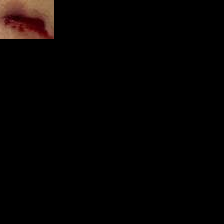

In [44]:
Image.open(X_train_5[Indx])

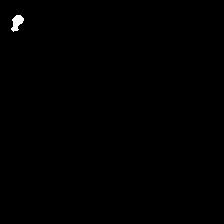

In [45]:
Image.open(Y_train_5[Indx])

----------

## Cargar los paths de las imagenes X_train y etiquetas Y_train:

In [7]:
import pandas as pd
import io

df = pd.read_csv('/content/FootSegmentation_4/train_images2.csv')    # df de los paths de las imágenes y los labels(masks)

In [8]:
X_train = [path_img for path_img in df['images']]
Y_train = [path_mask for path_mask in df['masks']]

# Conjuntos reducidos:
ind_redc = 150
X_train = X_train[:ind_redc]
Y_train = Y_train[:ind_redc]

Checamos a ojo que estén bien:

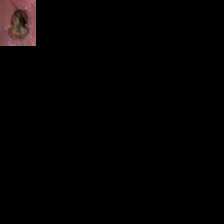

In [9]:
Image.open(X_train[48])

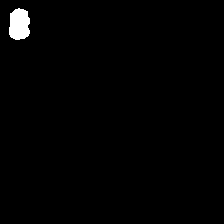

In [10]:
Image.open(Y_train[48])

Ahora sí entrenamos el modelo con la función (con CPU):

In [120]:
trained_unet_model = train_unet_model(X_train, Y_train, input_shape=(224, 224, 3), batch_size=16, epochs=4)   # Este es el modelo entrenado unet con tflite

Epoch 1/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 207s 68s/step - accuracy: 0.8498 - loss: 0.6380 - val_accuracy: 0.9530 - val_loss: 0.5655
Epoch 2/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 190s 60s/step - accuracy: 0.9642 - loss: 0.4085 - val_accuracy: 0.9530 - val_loss: 0.3023
Epoch 3/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 192s 59s/step - accuracy: 0.9683 - loss: 0.1684 - val_accuracy: 0.9530 - val_loss: 0.0861
Epoch 4/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 180s 59s/step - accuracy: 0.9675 - loss: 0.0882 - val_accuracy: 0.9530 - val_loss: 0.0909
Saved artifact at '/tmp/tmp2af8jjan'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_46')
Output Type:
  TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None)
Captures:
  132681034982400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132681038034400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132681034980288: TensorSpec(shape=(), dtype=tf.resource, name

Predicción de la imágen:

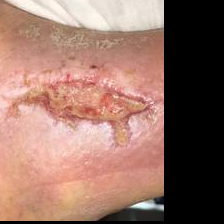

In [11]:
path_predicted_img = df['images'][14]
Image.open(path_predicted_img)

In [80]:
predicted_img = predict_mask(path_predicted_img, '/content/unet_model.tflite')

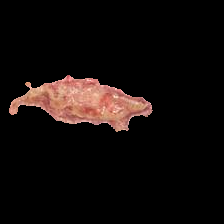

In [81]:
predicted_img[1]

# Entrenamiento de la U-Net con GPU:

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
import tensorflow as tf
import numpy as np
from PIL import Image

def load_images(image_paths):
    return np.array([np.array(Image.open(img).convert('RGB')) for img in image_paths])

def load_masks(mask_paths):
    return np.array([np.array(Image.open(mask).convert('L')) for mask in mask_paths])

def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Downsampling path
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)

    # Upsampling path
    u6 = tf.keras.layers.UpSampling2D((2, 2))(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)

    u7 = tf.keras.layers.UpSampling2D((2, 2))(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)

    u8 = tf.keras.layers.UpSampling2D((2, 2))(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)

    u9 = tf.keras.layers.UpSampling2D((2, 2))(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return tf.keras.models.Model(inputs, outputs)

def train_unet_model(image_paths, mask_paths, input_shape=(128, 128, 3), batch_size=16, epochs=50):
    images = load_images(image_paths)
    masks = load_masks(mask_paths)

    # Normalize images and masks
    images = images / 255.0
    masks = masks / 255.0

    with tf.device('/GPU:0'):  # Cambia '/GPU:0' si tienes más de una GPU y deseas especificar una diferente
        model = unet_model(input_shape)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(images, masks, batch_size=batch_size, epochs=epochs, validation_split=0.1)

        # Convert to TensorFlow Lite
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()

    # Save the model
    with open('unet_model_gpu.tflite', 'wb') as f:
        f.write(tflite_model)

    return tflite_model

In [88]:
trained_unet_model = train_unet_model(X_train, Y_train, input_shape=(224, 224, 3), batch_size=16, epochs=80)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.9348 - loss: 0.5724 - val_accuracy: 0.9773 - val_loss: 0.0927
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - accuracy: 0.9733 - loss: 0.0791 - val_accuracy: 0.9773 - val_loss: 0.0535
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.9744 - loss: 0.0641 - val_accuracy: 0.9773 - val_loss: 0.0501
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.9718 - loss: 0.0652 - val_accuracy: 0.9773 - val_loss: 0.0538
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.9726 - loss: 0.0610 - val_accuracy: 0.9773 - val_loss: 0.0641
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.9734 - loss: 0.0616 - val_accuracy: 0.9773 - val_loss: 0.0562
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.9741 - loss: 0.0582 - val_accuracy: 0.9773 - val_loss: 0.0452
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.9729 - loss: 0.0573 - val_accuracy: 0.9797 - val_loss: 

### Probamos con una imágen con el modelo .tflite (Regina)

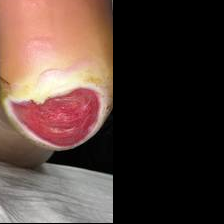

In [13]:
path_predicted_img = df['images'][34]   #Cargamos el path de una imágen del conjunto de imágenes.
Image.open(path_predicted_img)

In [14]:
predicted_img = predict_mask(path_predicted_img, '/content/unet_model_gpu.tflite')

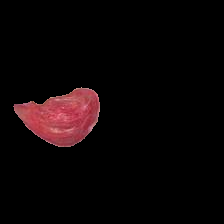

In [15]:
predicted_img[1]

# Guardar y cargar el modelo unet tflite:

*Evaluación:

In [142]:
X_test = [path_img for path_img in df['images']]
Y_test = [path_mask for path_mask in df['masks']]

# Conjuntos reducidos:
ind_redc = 90
X_test = X_train[1:ind_redc]
Y_test = Y_train[1:ind_redc]

In [154]:
metrics = evaluate_model(X_test, Y_test, '/content/unet_model_gpu.tflite')

In [156]:
# return {
#         'Dice Coefficient': np.mean(dice_scores),
#         'Precision': np.mean(precisions),
#         'Accuracy': np.mean(accuracies),
#         'AUC': np.mean(aucs)
#     }
metrics['precision']

nan

In [148]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def evaluate_model(X_test, Y_test, tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    dice_scores = []
    precisions = []
    accuracies = []
    aucs = []

    for i in range(len(X_test)):
        image = Image.open(X_test[i]).convert('RGB')
        input_data = np.array(image) / 255.0
        input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get the output (predicted mask)
        y_pred = interpreter.get_tensor(output_details[0]['index'])[0]

        # Reshape and threshold predicted mask
        y_pred = np.squeeze(y_pred)
        y_pred = (y_pred > 0.5).astype(np.uint8)

        # Reshape ground truth mask
        y_true = Image.open(Y_test[i]).convert('L')
        y_true = np.array(y_true) / 255.0
        y_true = (y_true > 0.5).astype(np.uint8)

        # Calculate Dice coefficient
        dice = dice_coefficient(y_true, y_pred)
        dice_scores.append(dice.numpy())

        # Calculate Precision
        precision = precision_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
        precisions.append(precision)
        print(precision)

        # Calculate Accuracy
        accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
        accuracies.append(accuracy)

        # Calculate AUC
        try:
            auc = roc_auc_score(y_true.flatten(), y_pred.flatten())
            aucs.append(auc)
        except ValueError:
            # Handle cases where AUC calculation fails (e.g., when all true labels are the same)
            aucs.append(np.nan)

    # Compile metrics into a dictionary
    metrics = {
        'dice_coefficient': dice_scores,
        'precision': np.nanmean(precisions),
        'accuracy': np.nanmean(accuracies),
        'auc': np.nanmean(aucs)
    }

    return metrics


In [153]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
import tensorflow as tf
from PIL import Image

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def evaluate_model(X_test, Y_test, tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    dice_scores = []
    precisions = []
    accuracies = []
    aucs = []

    for i in range(len(X_test)):
        # Load and preprocess the image
        image = Image.open(X_test[i]).convert('RGB')
        input_data = np.array(image) / 255.0
        input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get the output (predicted mask)
        y_pred = interpreter.get_tensor(output_details[0]['index'])[0]

        # Ensure predicted mask is binary
        y_pred = np.squeeze(y_pred)
        y_pred = (y_pred > 0.5).astype(np.uint8)

        # Load the ground truth mask
        y_true = Image.open(Y_test[i]).convert('L')
        y_true = np.array(y_true) / 255.0
        y_true = (y_true > 0.5).astype(np.uint8)

        # Check if the masks are non-empty
        if np.sum(y_true) == 0 or np.sum(y_pred) == 0:
            continue

        # Calculate Dice coefficient
        dice = dice_coefficient(y_true, y_pred)
        dice_scores.append(dice)

        # Calculate Precision
        precision = precision_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
        precisions.append(precision)

        # Calculate Accuracy
        accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
        accuracies.append(accuracy)

        # Calculate AUC
        try:
            auc = roc_auc_score(y_true.flatten(), y_pred.flatten())
            aucs.append(auc)
        except ValueError:
            aucs.append(np.nan)

    # If lists are still empty, return NaNs
    if len(dice_scores) == 0:
        return {
            'dice_coefficient': np.nan,
            'precision': np.nan,
            'accuracy': np.nan,
            'auc': np.nan
        }

    # Compile metrics into a dictionary
    metrics = {
        'dice_coefficient': np.nanmean(dice_scores),
        'precision': np.nanmean(precisions),
        'accuracy': np.nanmean(accuracies),
        'auc': np.nanmean(aucs)
    }

    return metrics
